In [0]:
from sklearn.datasets import make_blobs
import numpy as np
from pyspark.sql.functions import monotonically_increasing_id
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [0]:
features, true_labels = make_blobs(
   ...:     n_samples=200,
   ...:     centers=3,
   ...:     cluster_std=2.75,
   ...:     random_state=42
   ...: )

In [0]:
features

array([[ 9.77075874e+00,  3.27621022e+00],
       [-9.71349666e+00,  1.12745180e+01],
       [-6.91330582e+00, -9.34755911e+00],
       [-1.08618591e+01, -1.07506350e+01],
       [-8.50038027e+00, -4.54370383e+00],
       [-4.82456978e+00, -5.20159136e+00],
       [-3.03819028e+00,  9.84354132e+00],
       [-8.17498253e+00, -6.24197227e+00],
       [ 3.91207254e+00,  9.45363489e+00],
       [-4.64425636e+00, -5.14863028e+00],
       [ 2.09082004e+00,  1.80947495e+00],
       [ 5.26539366e+00,  5.56781226e+00],
       [ 7.61826975e+00,  4.87112533e+00],
       [ 3.30512908e+00,  2.19832357e+00],
       [-9.29263277e-01,  2.48591905e+00],
       [-9.15936347e+00, -8.42060745e+00],
       [-2.70722546e+00,  1.17740016e+01],
       [-9.14073328e+00, -6.20996976e+00],
       [ 6.52709436e+00, -2.46179896e+00],
       [-2.51808095e+00, -1.02841022e+01],
       [ 1.04758084e+01,  4.81244915e+00],
       [ 3.33377923e+00,  1.76514294e-01],
       [-5.99215115e+00, -9.15499469e+00],
       [-2.

In [0]:
np.concatenate(features, true_labels)


---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File <command-2189833016772133>, line 1
----> 1 np.concatenate(features, true_labels)

File <__array_function__ internals>:180, in concatenate(*args, **kwargs)

TypeError: only integer scalar arrays can be converted to a scalar index

In [0]:
df1 = spark.createDataFrame(features,['feature1','feature2'])
df1 = df1.withColumn("id1", monotonically_increasing_id())
df2 = spark.createDataFrame(true_labels,['label'])
df2 = df2.withColumn("id1", monotonically_increasing_id())

In [0]:
df = df1.join(df2,on="id1")
df.show(5)


+---+-------------------+-------------------+-----+
|id1|           feature1|           feature2|label|
+---+-------------------+-------------------+-----+
|  0|  9.770758741876183| 3.2762102164481477|    1|
|  1| -9.713496659299548| 11.274518015230187|    0|
|  2| -6.913305816480285| -9.347559114861983|    2|
|  3|-10.861859130268911|-10.750634972811474|    2|
|  4|  -8.50038027274785| -4.543703826468128|    2|
+---+-------------------+-------------------+-----+
only showing top 5 rows



In [0]:
assembler = VectorAssembler(inputCols=["feature1", "feature2"],
                            outputCol="features")
data_df = assembler.transform(df)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)
data_df.show(5)

+---+-------------------+-------------------+-----+--------------------+--------------------+
|id1|           feature1|           feature2|label|            features|     scaled_features|
+---+-------------------+-------------------+-----+--------------------+--------------------+
|  0|  9.770758741876183| 3.2762102164481477|    1|[9.77075874187618...|[1.82968666370121...|
|  1| -9.713496659299548| 11.274518015230187|    0|[-9.7134966592995...|[-1.8189636818331...|
|  2| -6.913305816480285| -9.347559114861983|    2|[-6.9133058164802...|[-1.2945958229721...|
|  3|-10.861859130268911|-10.750634972811474|    2|[-10.861859130268...|[-2.0340077284354...|
|  4|  -8.50038027274785| -4.543703826468128|    2|[-8.5003802727478...|[-1.5917937216868...|
+---+-------------------+-------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [0]:
kmeans = KMeans(k=3, featuresCol="scaled_features", predictionCol="cluster")
model = kmeans.fit(data_df)

In [0]:
predictions = model.transform(data_df)
predictions.show(5)

+---+-------------------+-------------------+-----+--------------------+--------------------+-------+
|id1|           feature1|           feature2|label|            features|     scaled_features|cluster|
+---+-------------------+-------------------+-----+--------------------+--------------------+-------+
|  0|  9.770758741876183| 3.2762102164481477|    1|[9.77075874187618...|[1.82968666370121...|      1|
|  1| -9.713496659299548| 11.274518015230187|    0|[-9.7134966592995...|[-1.8189636818331...|      0|
|  2| -6.913305816480285| -9.347559114861983|    2|[-6.9133058164802...|[-1.2945958229721...|      2|
|  3|-10.861859130268911|-10.750634972811474|    2|[-10.861859130268...|[-2.0340077284354...|      2|
|  4|  -8.50038027274785| -4.543703826468128|    2|[-8.5003802727478...|[-1.5917937216868...|      2|
+---+-------------------+-------------------+-----+--------------------+--------------------+-------+
only showing top 5 rows



In [0]:
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
#evaluator = ClusteringEvaluator()
silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette_score:.4f}")

Silhouette Score: 0.7851


In [0]:
#finding the optimal number of clusters
# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,8):    
    KMeans_mod = KMeans(k=i, featuresCol="scaled_features", predictionCol="cluster")  
    KMeans_fit = KMeans_mod.fit(data_df)  
    output = KMeans_fit.transform(data_df)   
    score = evaluator.evaluate(output)   
    wssse_values.append(score)  
    print("Silhouette Score:",score)

Silhouette Score: 0.7178670008193637
Silhouette Score: 0.7851032706829328
Silhouette Score: 0.6726486143551612
Silhouette Score: 0.5810267089116743
Silhouette Score: 0.5446619451331941
Silhouette Score: 0.5228633085259329


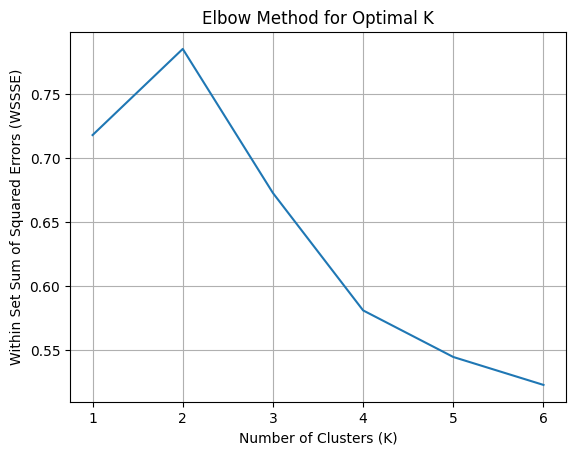

In [0]:
# Plotting WSSSE values
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

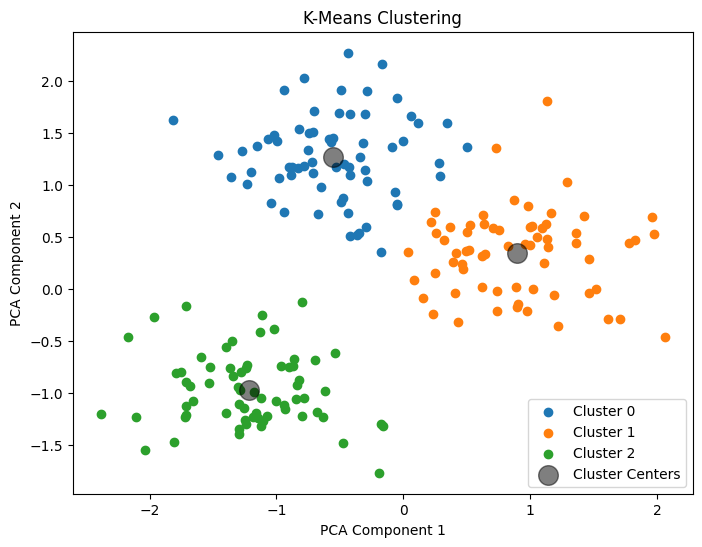

In [0]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
for i in range(3):
    cluster_data = predictions.filter(predictions["cluster"] == i).select("scaled_features").collect()
    cluster_points = [point[0] for point in cluster_data]
    plt.scatter(*zip(*cluster_points), label=f"Cluster {i}")

plt.scatter(*zip(*model.clusterCenters()), c='black', s=200, alpha=0.5, label="Cluster Centers")
plt.title("K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()